In [37]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
import shutil

In [47]:
#1. gather data from the internet
key = os.environ.get('AZURE_SEARCH_KEY', '5ee62e8618d44fa08f779d874f23ad0d')

drink_types = 'stardew valley','terraria','overcooked'
[print(o) for o in drink_types]
path = Path('games')

if not path.exists():
    path.mkdir()

for o in drink_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o}')
    download_images(dest, urls=results.attrgot('contentUrl'))

stardew valley
terraria
overcooked


In [48]:
#2. double check paths correct
fns = get_image_files(path)
fns

(#489) [Path('games/overcooked/00000047.jpg'),Path('games/overcooked/00000055.jpg'),Path('games/overcooked/00000064.png'),Path('games/overcooked/00000011.png'),Path('games/overcooked/00000107.jpg'),Path('games/overcooked/00000036.jpg'),Path('games/overcooked/00000030.jpg'),Path('games/overcooked/00000097.jpg'),Path('games/overcooked/00000148.jpg'),Path('games/overcooked/00000110.jpg')...]

In [49]:
#3. check and remove failed images (those that could not be opened)
failed = verify_images(fns)
failed
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [50]:
#4. Tell fastai what the DATA FORMAT WILL BE for model training
#blocks -> defines independent and dependent variable type
#get_image_files -> takes path and returns all images at end of list
#splitter -> test/trian
#parent_label -> gets path directoty folder name
drinks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


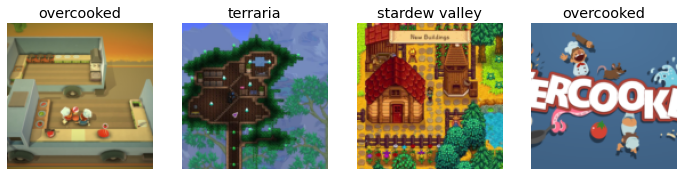

In [51]:
# 5. look at the data and confirm it
dls = drinks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

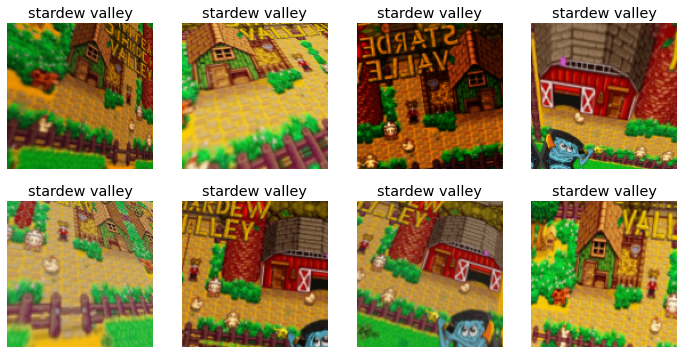

In [52]:
# 5.5. edgy variation
drinks = drinks.new(item_tfms=RandomResizedCrop(128, min_scale=0.3), batch_tfms=aug_transforms(mult=2))
dls = drinks.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [53]:
# 6. Load data for model on the data

drinks = drinks.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = drinks.dataloaders(path)

In [54]:
#7. Train CNN model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.488341,0.483125,0.187500,00:08


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.339489,0.360457,0.135417,00:09
1,0.244762,0.576478,0.218750,00:09
2,0.200623,0.717597,0.250000,00:09
3,0.158811,0.768086,0.250000,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


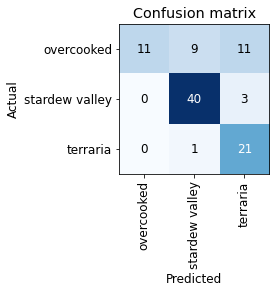

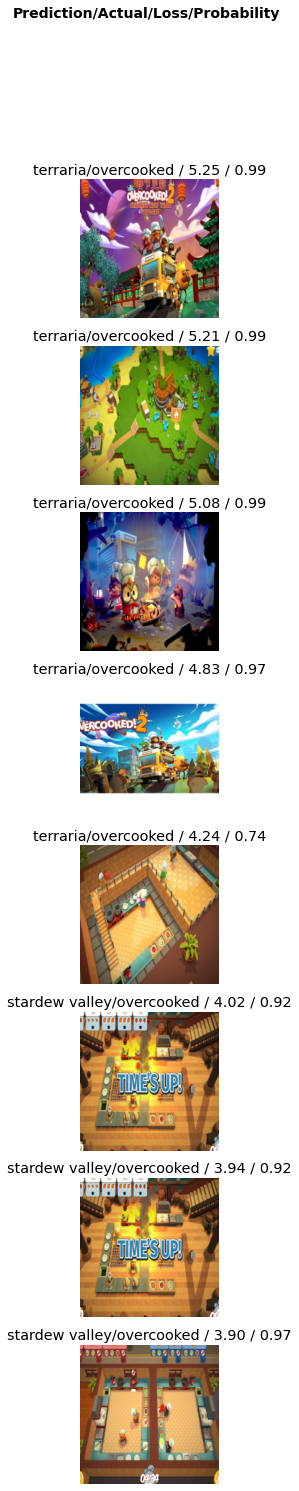

In [55]:
#8. Plot confusion matrix/metric analysis of model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(8, nrows=8)

In [56]:
# create simple notebook app
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

In [65]:
#hide_output
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
# out_pl.clear_output()
# with out_pl: display(img.to_thumb(128,128))
# pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='What Game?')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'This game is \"{pred}\" [propability: {probs[pred_idx]:.04f}]'

btn_run.on_click(on_click_classify)

In [66]:
VBox([widgets.Label('Upload the image that is on their screen.'), 
      btn_upload, btn_run, out_pl, lbl_pred])